In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
path = untar_data(URLs.MNIST)

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [0]:
il = ImageList.from_folder(path, convert_mode='L')

In [0]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/training/6/27355.png')

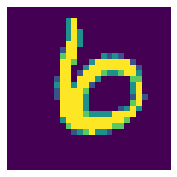

In [0]:
il[0].show()

In [0]:
defaults.cmap='binary'

In [0]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

In [0]:
sd = il.split_by_folder(train='training', valid='testing')

In [0]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/7')]

In [0]:
ll = sd.label_from_folder()

In [0]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
6,6,6,6,6
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
6,6,6,6,6
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
x,y = ll.train[0]

torch.Size([1, 28, 28]) 6


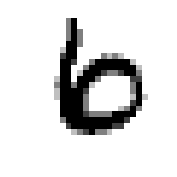

In [0]:
x.show()
print (x.shape, y)

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [0]:
ll = ll.transform(tfms)

In [0]:
bs = 128

In [0]:
data = ll.databunch(bs=bs).normalize()

In [0]:
x,y =  data.train_ds[0]

torch.Size([1, 28, 28]) 6


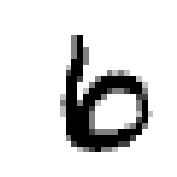

In [0]:
x.show()
print (x.shape, y)

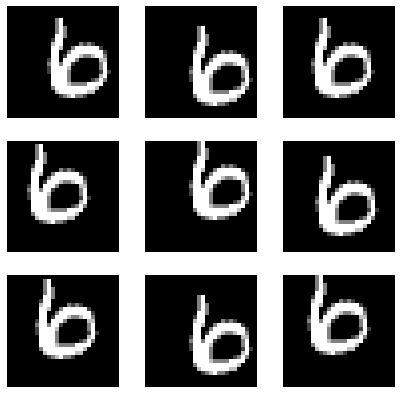

In [0]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(7,7))

In [0]:
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

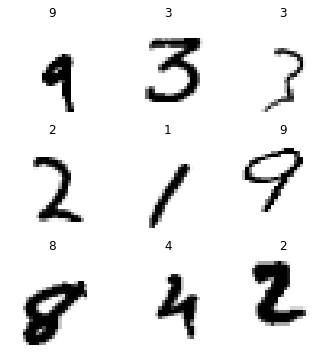

In [0]:
data.show_batch(rows=3, figsize=(5,5))

**CNN from Scratch**

In [0]:
def conv(xi, xf): return nn.Conv2d(xi, xf, kernel_size=3, stride=2, padding=1)

In [0]:
model = nn.Sequential(
    conv(1, 8),  # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32),  # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16),  # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10),  # 1
    nn.BatchNorm2d(10),
    Flatten() # remove 1x1 grid

)

In [0]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [0]:
xb = xb.cuda()

In [0]:
model(xb).shape

torch.Size([128, 10])

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


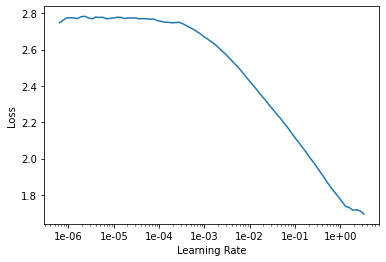

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,0.213133,0.305011,0.903400,00:35
1,0.129075,0.081421,0.973400,00:35
2,0.071601,0.038464,0.987600,00:35


**Refractor**

In [0]:
def conv2(xi, xf): return conv_layer(xi, xf, stride=2)

In [0]:
model = nn.Sequential(
    conv2(1, 8),
    conv2(8, 16),
    conv2(16, 32),
    conv2(32, 16),
    conv2(16, 10),
    Flatten()

)

In [0]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
learn.fit_one_cycle(10, max_lr=1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,0.240319,0.210711,0.932300,00:34
1,0.194917,0.154743,0.954500,00:35
2,0.174833,0.094594,0.970000,00:34
3,0.156374,0.105545,0.965300,00:34
4,0.122213,0.067279,0.978300,00:34
5,0.105731,0.062942,0.980800,00:35
6,0.088322,0.066470,0.979300,00:35
7,0.067151,0.035120,0.988700,00:35
8,0.050463,0.026284,0.991600,00:34
9,0.045596,0.025285,0.992000,00:35


**RESNETs**

In [0]:
class ResnetBlock(nn.Module):
  def __init__(self, xf):
    super.__init__()
    self.conv1 = conv_layer(xf, xf)
    self.conv2 = conv_layer(xf, xf)


  def forward(self , x): return x + self.conv2(self.conv1(x))

In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res(xi,xf): return nn.Sequential(conv2(xi, xf), res_block(xf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


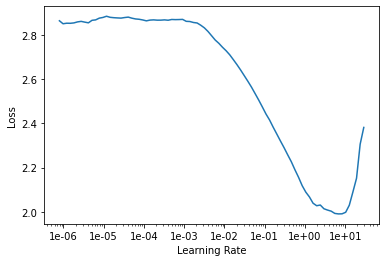

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(12, max_lr=(1e-01)/2)

epoch,train_loss,valid_loss,accuracy,time
0,0.199078,0.142954,0.957400,00:40
1,0.134318,0.360085,0.887400,00:40
2,0.102429,0.121025,0.963900,00:41
3,0.081354,0.223016,0.925400,00:40
4,0.070422,0.047718,0.983900,00:40
5,0.069199,0.071633,0.978500,00:40
6,0.062350,0.075784,0.975200,00:40
7,0.043284,0.028809,0.991500,00:40
8,0.029941,0.021926,0.992800,00:40
9,0.028281,0.018189,0.994400,00:40


In [0]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________